In [1]:
import sys

sys.path.append("src/")

In [2]:
import projet9_functions as p9

2023-11-15 18:46:43.021985: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-15 18:46:43.493295: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-15 18:46:43.493367: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-11-15 18:46:43.493372: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
!{sys.executable} src/popularity.py

2023-11-08 18:11:32.160495: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-08 18:11:32.160561: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-11-08 18:11:32.160569: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2023/11/08 18:11:33 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/11/08 18:11:33 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.r

In [12]:
!{sys.executable} src/content_based.py

2023-11-13 17:06:30.036128: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-13 17:06:30.036197: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-11-13 17:06:30.036205: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2023/11/13 17:06:31 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/11/13 17:06:31 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.r

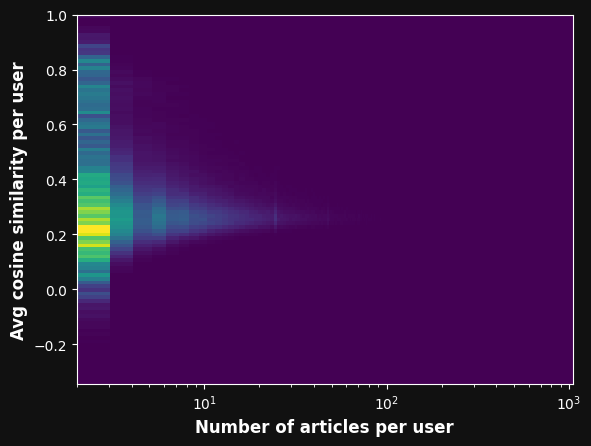

In [3]:
import pandas as pd

df = pd.read_csv("data/clicks.csv")
p9.get_average_similarity(df)

In [14]:
!{sys.executable} src/SVD.py

2023-11-13 17:27:42.500739: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-13 17:27:42.500806: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-11-13 17:27:42.500814: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2023/11/13 17:27:43 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/11/13 17:27:43 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.r

Essai max_sampled 1000, 5000, 10000


In [47]:
!{sys.executable} src/model_lightfm.py

2023-11-21 15:06:40.768672: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-21 15:06:40.768738: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-11-21 15:06:40.768747: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2023/11/21 15:06:42 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/11/21 15:06:42 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.r

relancer plus tard


In [119]:
!{sys.executable} src/bpr.py

2023/11/30 15:23:59 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/11/30 15:23:59 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
model
  6%|▍        | 11/200 [00:02<00:43,  4.39it/s, train_auc=50.65%, skipped=4.04%]^C


In [128]:
!{sys.executable} src/hybrid.py -m

[2023-11-30 15:41:41,618][HYDRA] Launching 16 jobs locally
[2023-11-30 15:41:41,618][HYDRA] 	#0 : n_factor=50 thr_pop=0
2023/11/30 15:41:41 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/11/30 15:41:41 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
100%|████████| 200/200 [00:14<00:00, 14.28it/s, train_auc=97.21%, skipped=4.04%]
apply collaborative filtering recommender
400000it [00:40, 9807.13it/s]
[2023-11-30 15:42:49,115][HYDRA] 	#1 : n_factor=50 thr_pop=3
100%|████████| 200/200 [00:15<00:00, 13.06it/s, train_auc=97.19%, skipped=4.01%]
apply popularity recommender
apply collaborative filtering recommender
400000it [00:25, 15450.51it/s]
[2023-11-30 15:44:23,486][HYDRA] 	#2 : n_factor=50 thr_pop=6
10